In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

#This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# **Part 1 - Data Preprocessing**

In [ ]:
df = pd.read_csv('Alcohol_Sales.csv', index_col = 0, parse_dates = True) #index_col = 0 grabs the first column and sets it to the index, parse_dates = True automatically makes pandas convert the index into a date time object
df #data goesfrom jan-1992 to jan-2019 with 325 points of data

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221
...,...
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174


In [ ]:
df = df.dropna() #dropping any null values
len(df) #length is the same, so there were no null values

325

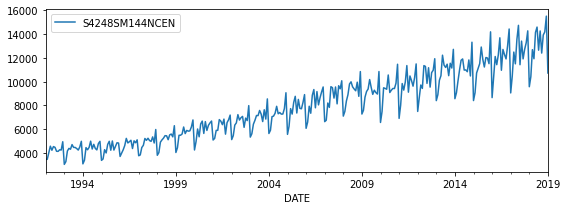

In [ ]:
df.plot(figsize=(9,3)) #notice the general increase in sales over the years, but there is clear seasonality

In [ ]:
df['S4248SM144NCEN'].dtype #lets convert this into a float for when we're predicting

dtype('int64')

In [ ]:
y = df['S4248SM144NCEN'].values.astype(float)
y.dtype

dtype('float64')

In [ ]:
test_size = 12 #using our last year to compare our predictions

train_set = y[:-test_size] #using all the years before 2018 to train
test_set = y[-test_size:]
print(test_set)
print(len(train_set))
print(len(test_set))

[10415. 12683. 11919. 14138. 14583. 12640. 14257. 12396. 13914. 14174.
 15504. 10718.]
313
12


Normalizing Data

In [ ]:
#We need to normalize the data between -1 and 1, and we normalize the data because RNN's typically train better due to the way weights and biases update after normalization
#In this dataset, we can see an order of magnitude change going from ~4000 to ~16000. When we have a very large change in data magnitude, it's a better idea to normalize the data
scaler = MinMaxScaler(feature_range=(-1,1)) #so here we're scaling the values down from -1 to 1

train_norm = scaler.fit_transform(train_set.reshape(-1,1))  #now we're fitting the scaling to the train_set then we're actually transforming our data to be between -1 and 1

train_norm[0:10] #notice how all the values are between -1 and 1 now

array([[-0.92683135],
       [-0.92700231],
       [-0.83400291],
       [-0.73792632],
       [-0.79656381],
       [-0.74390974],
       [-0.75467989],
       [-0.81092401],
       [-0.81280451],
       [-0.79006753]])

In [ ]:
window_size = 12 #chose 12 to take into considertion the different seasonalities of a year

Converting Data to Tensor

In [ ]:
#Now let's convert the normalized training set into a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)
print(len(train_norm))
print(train_norm.dtype)

313
torch.float32


In [ ]:
def input_data(train_seq, window_size):
  #takes in training sequence and window size
  out = [] #is gonna be a list of tuples providing the sequence and training point
  #for example ([0,1,2,3],[4]), ([1,2,3,4],[5]), etc
  L = len(train_seq) #total length of our sequence

  for i in range(L-window_size):
    #for loop is from total number of sequences, L, subtracted by window size, since window size determines the number of points to use in the sequence (i.e. ([1,2,3,4], [5]) the window size is 4)
    window = train_seq[i:i+window_size] #window size = sequence size, so like if we're at i'th index, take the points that are window_size units above it (i.e. if i = 10, and window_size = 4, the window will be 10, 11, 12, 13)
    label = train_seq[i+window_size:i+window_size+1] #so our label (training point) will be 1 point into the future (i.e if window is 10,11,12,13, then label is 14)
    out.append((window,label))

  return out

train_data = input_data(train_norm, window_size)
len(train_data) #301 makes sense, since train_set is 325 - 12, then range of predictions is L = len(train_set) - ws = 325 - 12 -12

301

In [ ]:
train_data[1] #so see how first tuple is the first 12 points, and second tuble is the prediction

(tensor([-0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109, -0.8128,
         -0.7901, -0.7933, -0.6743, -1.0000]), tensor([-0.9607]))

# **Part 2 - Creating our LSTM RNN Model**

In [ ]:
class LSTM(nn.Module):
  
  def __init__(self, in_size=1, hid_size=125, out_size = 1):
    #we have input size of 1 since it's a single tuple of y values (but there can be multiple within this tuple, as shown in the example above with 40 data points)
    #we have output size of 1, since we just have 1 tuple (with a single value that predicts 1 point into the future)
    #hidden state is something we can play around with and it's how many neurons we want
    super().__init__() #super is a function that allows us to use Module's functions and variables, while also optimizing this inheritance process
    self.hid_size = hid_size
    
    #Adding LSTM layer
    self.lstm = nn.LSTM(in_size, hid_size) #so here we're creating an LSTM that takes in the input size and the hidden layer size
    
    #Adding fully connected layer
    self.linear = nn.Linear(in_features = hid_size, out_features = out_size) #now we're creating a fully connected layer that takes the hidden LSTM layers and converts it into a single output

    #Initializing h0 and c0
    self.hidden = (torch.zeros(1, 1, hid_size),
                   torch.zeros(1, 1, hid_size)) 
    #so recall the LSTM takes in 3 inputs: x(t), h(t-1), c(t-1), so we're passing 3 tensors into the LSTM layer
    #we are using self.hidden to basically initialize this hidden state, h(t-1), and cell state, c(t-1)
    #so we're creating a 1x1xhidden_size matrix with only zeros, and output the hidden_size

  def forward(self, sequence):
    lstm_out , self.hidden = self.lstm(sequence.view(len(sequence),1,-1), self.hidden) #so our lstm expects inputs as: input, (h_0, c_0) = (sequence_len, batch, in_size), (h_0, c_0)
    #so our first tuple contains len of the sequence, batch size, and input size. second tuple contains the hidden state and cell state initialized above
    #lstm outputs: output, (h_n, c_n) = (sequence_len, batch, num_directions * hid_size), (h_n, c_n), so we're doing tuple unpacking to update our hidden_state and creating a new variable for the for the output

    pred = self.linear(lstm_out.view(len(sequence), -1)) #so we're using the nn.Linear from above to basically make a fully connected layer between the LSTM output and the predicted output
    #we did the the in_features as (len(sequence), -1) because recall the LSTM output is (sequence_len, batch, num_directions * hid_size)
    #output will be implied to be 1, as already made in init

    y_final = pred[-1] #so pred will include everything including the sequence values and the training point prediction (so instead of just 4, it'll have (1,2,3,4)). As such, we're using -1 to grab just the last value
    return y_final 

In [ ]:
model = LSTM()
model

LSTM(
  (lstm): LSTM(1, 125)
  (linear): Linear(in_features=125, out_features=1, bias=True)
)

In [ ]:
criterion = nn.MSELoss() #so our loss measurement will be Mean Squared Error loss since this is a regression problem

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) #model parameters are just the fully connected layers and we are using Adam optimizer to optimize them
model.parameters #can see the parameters are just the fully connected layers and we are optimizing them

<bound method Module.parameters of LSTM(
  (lstm): LSTM(1, 125)
  (linear): Linear(in_features=125, out_features=1, bias=True)
)>

# **Part 3 - Training Our Model**

In [ ]:
import time #Gonna try to keep track of how long it takes to train our model

start_time = time.time()

epochs = 200
future = 12

for i in range(epochs):
  #Forward propagation through our ANN using training data

  for sequence, y_train in train_data:
    #recall train data has 2 tuples, the first one being the sequence data (12 points) and the second one being the label
    optimizer.zero_grad() #resetting the gradient on the optimizer so it doesn't accumulate
    model.hidden = (torch.zeros(1,1,model.hid_size),
                    torch.zeros(1,1,model.hid_size))
    #so recall the LSTM takes in 3 inputs: x(t), h(t-1), c(t-1), so we're passing 3 tensors into the LSTM layer
    #we are using hidden to basically initialize this hidden state, h(t-1), and cell state, c(t-1)
    #so we're creating a 1x1 matrix with only zeros, and output the hidden_size

    y_pred = model.forward(sequence)

    #Calculating loss/error
    loss = criterion(y_pred, y_train)

    #Backpropagation
    loss.backward() #doing backpropagation off the loss function
    optimizer.step() #using the optimizer for the back propagation
  if i%25 == 0:
    print(f'Epoch: {i+1:2} Loss: {loss.item():10.8f}')

print(f'Training took {(time.time() - start_time)/60} minutes')

Epoch:  1 Loss: 0.27659056
Epoch: 26 Loss: 0.00001117
Epoch: 51 Loss: 0.00007314
Epoch: 76 Loss: 0.00511273
Epoch: 101 Loss: 0.00097003
Epoch: 126 Loss: 0.00112299
Epoch: 151 Loss: 0.00004740
Epoch: 176 Loss: 0.00263987
Training took 4.7728783567746484 minutes


In [ ]:
#Forecasting into Unknown Future
preds = train_norm[-window_size:].tolist() #here we're grabbing the very last window of our training set, so the very next thing we predict is the first number in the test set

model.eval()

#Now creating a for loop for the future predictions
for f in range(future):
  seq = torch.FloatTensor(preds[-window_size:]) #converting preds into a float Tensor where we only take the last 40 points. This list will continuously expand because we will append our predictions to it

  with torch.no_grad():
    model.hidden = (torch.zeros(1,1,model.hid_size),
                    torch.zeros(1,1,model.hid_size))
    preds.append(model(seq).item()) #so our preds starts off as just the last 40 points of the training set, but now we're adding our prediction to this list
  
#If we graph the predicted values now, we'll see the future value are still normalized, so they're between -1 and 1, instead of being in the actual range
#as such, we have to inverse the normalization

#Inversing the normalization
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1)) #reshaped from -1,1 to original unscaled values to fit correctly into our plot

x = np.arange('2018-02-01','2019-02-01', dtype='datetime64[M]') #adding a date column to our true_predictions, since rn it's only the prediction values with no dates

In [ ]:
true_predictions #see how the value are in the same scaling as the original

array([[10320.5062763 ],
       [12083.97472039],
       [11697.64265572],
       [13287.17631066],
       [14352.15931123],
       [11237.19248442],
       [13196.89915526],
       [12083.75402027],
       [12406.63270995],
       [13238.37543595],
       [14005.69360185],
       [ 9707.12338984]])

In [ ]:
df['S4248SM144NCEN'][-12:] #look at how close the final the last 12 values are to the predicted values, as well as the increase/decrease directions

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

In [ ]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', length=325, freq=None)

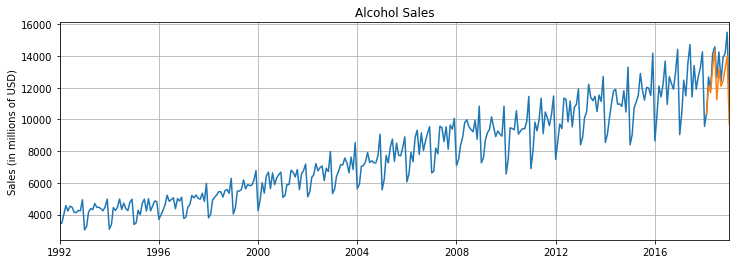

In [ ]:
plt.figure(figsize=(12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales (in millions of USD)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions) #plotting the true _predictions along dates, x
plt.show()

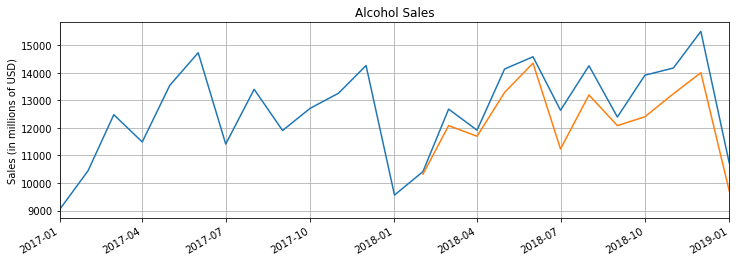

In [ ]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales (in millions of USD)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show() #we can see the general trends are the same

# **Part 4 - Training on All Data to Predict Non-Existing Data Points**

In [ ]:
import time #Gonna try to keep track of how long it takes to train our model

start_time = time.time()
#set model back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1)) #refitting and transforming our data into the proper scaling
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

epochs = 200
future = 12

#This for loop trains our NN
for i in range(epochs):
  #Forward propagation through our ANN using training data

  for sequence, y_train in train_data:
    #recall train data has 2 tuples, the first one being the sequence data (12 points) and the second one being the label
    optimizer.zero_grad() #resetting the gradient on the optimizer so it doesn't accumulate
    model.hidden = (torch.zeros(1,1,model.hid_size),
                    torch.zeros(1,1,model.hid_size))
    #so recall the LSTM takes in 3 inputs: x(t), h(t-1), c(t-1), so we're passing 3 tensors into the LSTM layer
    #we are using hidden to basically initialize this hidden state, h(t-1), and cell state, c(t-1)
    #so we're creating a 1x1 matrix with only zeros, and output the hidden_size

    y_pred = model.forward(sequence)

    #Calculating loss/error
    loss = criterion(y_pred, y_train)

    #Backpropagation
    loss.backward() #doing backpropagation off the loss function
    optimizer.step() #using the optimizer for the back propagation
  if i%25 == 0:
    print(f'Epoch: {i+1:2} Loss: {loss.item():10.8f}')

print(f'Training took {(time.time() - start_time)/60} minutes')

Epoch:  1 Loss: 0.00001430
Epoch: 26 Loss: 0.00003398
Epoch: 51 Loss: 0.00132414
Epoch: 76 Loss: 0.00186591
Epoch: 101 Loss: 0.00017462
Epoch: 126 Loss: 0.00003382
Epoch: 151 Loss: 0.00013126
Epoch: 176 Loss: 0.00029460
Training took 4.764552748203277 minutes


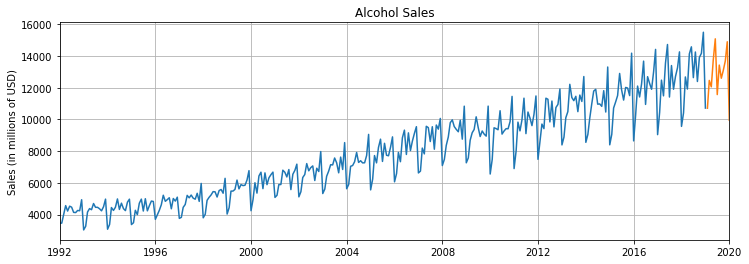

In [ ]:
#Forecasting into Unknown Future
preds = y_norm[-window_size:].tolist() #here we're grabbing the very last window of our training set, so the very next thing we predict is the first number in the test set

model.eval()

#Now creating a for loop for the future predictions
for f in range(future):
  seq = torch.FloatTensor(preds[-window_size:]) #converting preds into a float Tensor where we only take the last 40 points. This list will continuously expand because we will append our predictions to it

  with torch.no_grad():
    model.hidden = (torch.zeros(1,1,model.hid_size),
                    torch.zeros(1,1,model.hid_size))
    preds.append(model(seq).item()) #so our preds starts off as just the last 40 points of the training set, but now we're adding our prediction to this list

#Inversing the normalization
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1)) #reshaping from -1,1 to original unscaled values

#Adding a date range
x = np.arange('2019-02-01','2020-02-01', dtype='datetime64[M]') #adding a date column to our true_predictions, since rn it's only the prediction values with no dates

#Plotting
plt.figure(figsize=(12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales (in millions of USD)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions) #plotting the true _predictions along dates, x
plt.show()

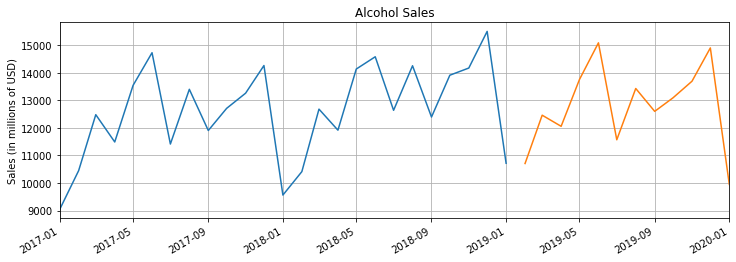

In [ ]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales (in millions of USD)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()